# Conditional Variational Autoencoder

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'cvae'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 24 * 24 * 222
hidden_dim = 576
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92


In [9]:
model = M.cvae.CVAE(input_dim, hidden_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()

train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model: pallets.models.cvae.CVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1422887.375000
INFO | epoch 1 ( 35%) loss: 90973.002901
INFO | epoch 1 ( 70%) loss: 51420.222360
INFO | epoch 1 (100%) loss: 38996.729947
INFO | epoch 1 (test) loss: 7079.896622
INFO | epoch 2 (  0%) loss: 7252.196289
INFO | epoch 2 ( 35%) loss: 6298.391553
INFO | epoch 2 ( 70%) loss: 5628.102177
INFO | epoch 2 (100%) loss: 5211.681871
INFO | epoch 2 (test) loss: 3843.845818
INFO | epoch 3 (  0%) loss: 3952.945312
INFO | epoch 3 ( 35%) loss: 3591.531513
INFO | epoch 3 ( 70%) loss: 3380.693630
INFO | epoch 3 (100%) loss: 3216.313632
INFO | epoch 3 (test) loss: 2664.408588
INFO | epoch 4 (  0%) loss: 2886.278320
INFO | epoch 4 ( 35%) loss: 2539.441965
INFO | epoch 4 ( 70%) loss: 2422.085775
INFO | epoch 4 (100%) loss: 2339.493400
INFO | epoch 4 (test) loss: 2127.593605
INFO | epoch 5 (  0%) loss: 2065.791260
INFO | epoch 5 ( 35%) loss: 1

# Results

## Random Inputs w/ Real Labels

In [10]:
import random

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [11]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0]
    decoded_one_hot = decoded_one_hot.view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms w/ Real Labels

Features: male, clownEyesBlue, crazyHair, cigarette
Shape: torch.Size([4, 24, 24])


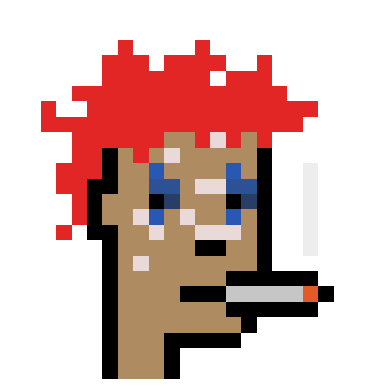

In [12]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, peakSpike, eyePatch
Shape: torch.Size([4, 24, 24])


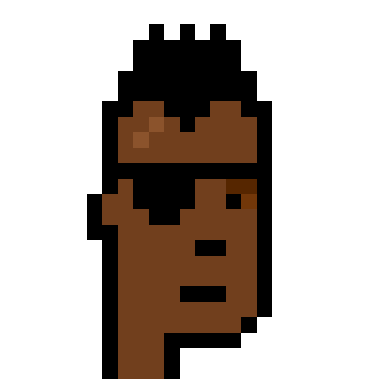

In [13]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, mohawkThin, mole
Shape: torch.Size([4, 24, 24])


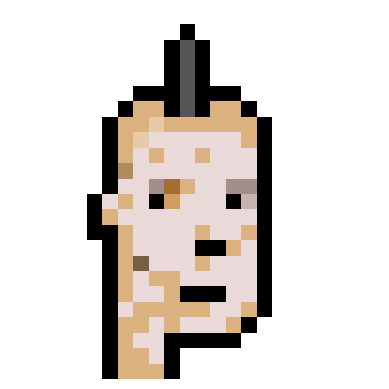

In [14]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, purpleEyeShadow, cap, cigarette
Shape: torch.Size([4, 24, 24])


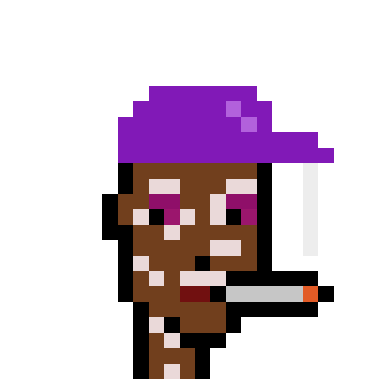

In [15]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, stringyHair
Shape: torch.Size([4, 24, 24])


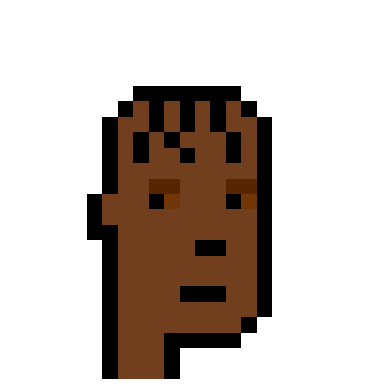

In [16]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [17]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(dataset._label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0].cpu()
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

Features: female, rosyCheeks, darkHair, cigarette


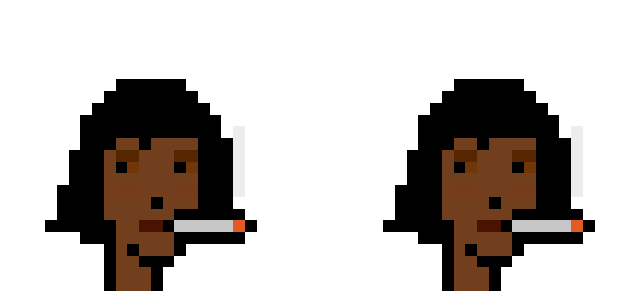

In [18]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


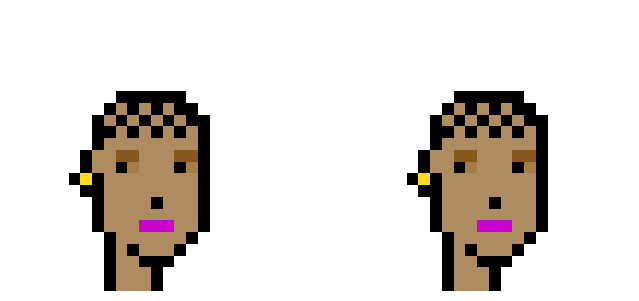

In [19]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


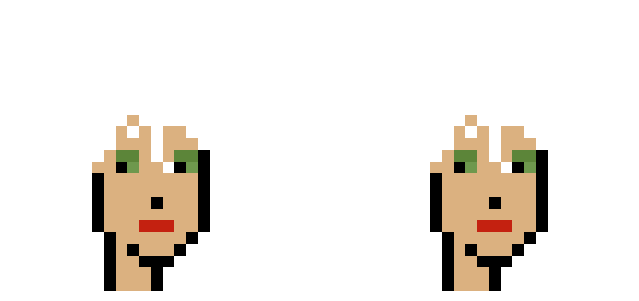

In [20]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


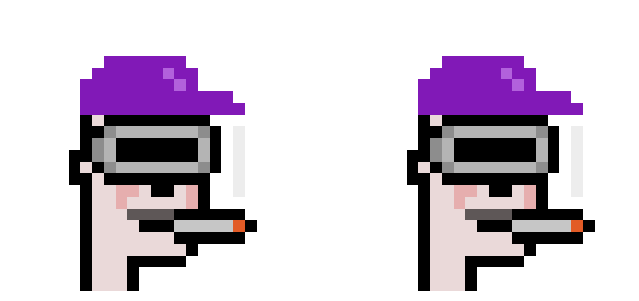

In [21]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


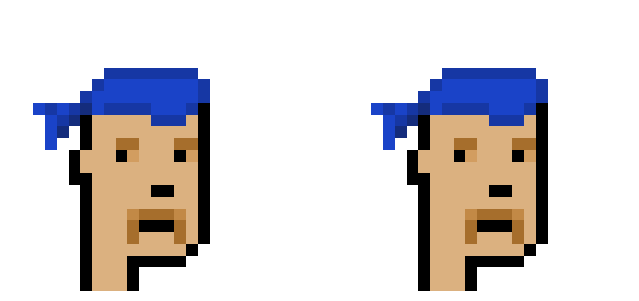

In [22]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

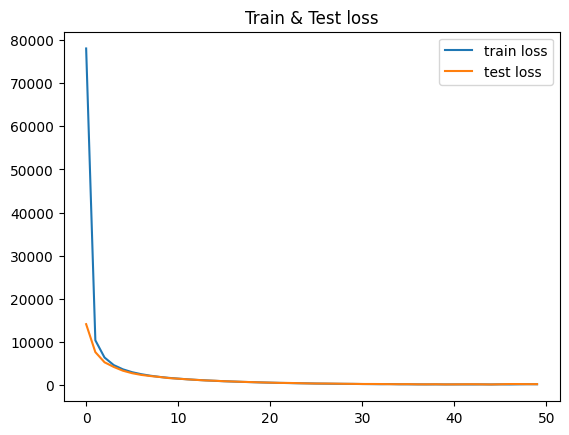

In [23]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [24]:
train_losses


[77993.45989340924,
 10423.36374182735,
 6432.627264793883,
 4678.986799524186,
 3701.0304517813606,
 3034.1118073159078,
 2570.6078216336296,
 2217.197640060533,
 1939.0874317791445,
 1721.8533670411887,
 1550.2650185442985,
 1393.6606340340688,
 1254.897825849817,
 1144.0868023811502,
 1037.7757749625132,
 946.3036388640708,
 866.7316576369266,
 795.2127706108364,
 732.4121194393077,
 671.6068627107228,
 612.3312921726957,
 568.0492743634163,
 521.9289981490331,
 478.5169764309065,
 453.05342015476094,
 407.96625039932576,
 382.0685673977466,
 356.7863326918149,
 340.89232271613804,
 326.20104653108206,
 299.2550123769341,
 280.05499803259016,
 258.91615262944646,
 282.36307017008465,
 239.09286791213015,
 231.4128674716814,
 214.62756449110964,
 206.9851871788079,
 214.38987203016347,
 201.31782082632077,
 205.74187740028327,
 207.1404960984034,
 200.1594230164873,
 213.6890443842462,
 194.11880233439993,
 220.75319003382472,
 202.41609981888575,
 230.167280034816,
 257.244374971863

In [25]:
test_losses


[14159.793243408203,
 7687.691635131836,
 5328.817176818848,
 4255.187210083008,
 3380.040407180786,
 2803.3888149261475,
 2405.8833389282227,
 2144.9053859710693,
 1928.362361907959,
 1676.0401554107666,
 1534.922534942627,
 1384.5588684082031,
 1254.2817268371582,
 1125.7854022979736,
 1056.2761521339417,
 947.0671820640564,
 881.6337523460388,
 802.0390605926514,
 742.608681678772,
 671.7897305488586,
 620.4999413490295,
 560.0746772289276,
 548.5281991958618,
 503.7481541633606,
 447.7081253528595,
 416.66386556625366,
 412.9250867366791,
 390.4771201610565,
 355.1408386230469,
 335.2843506336212,
 305.8167943954468,
 305.95685625076294,
 294.9788212776184,
 268.0333411693573,
 259.15514290332794,
 270.81958961486816,
 231.93807983398438,
 231.9630470275879,
 246.23867630958557,
 214.87341284751892,
 222.46665477752686,
 242.21910989284515,
 256.4220778942108,
 228.67119932174683,
 206.48618698120117,
 241.51651895046234,
 294.86340618133545,
 293.42593026161194,
 270.0608425140381